# Diffusion Models in PyTorch

## 0. Imports & Dataset (CelebFaces Attributes)

In [1]:
# Necessary Imports
import torch
import math
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# Hyperparameters, etc.
SHOW_SAMPLES = 16
SHOW_COLS = 4
T = 300
BETA_START = 1e-4
BETA_END = 2e-2
IMG_SIZE = 64
BATCH_SIZE = 128
EPOCHS = 0 # Change this to however much you want to train
LEARNING_RATE = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(device)

2.5.1+cpu
cpu


Files already downloaded and verified


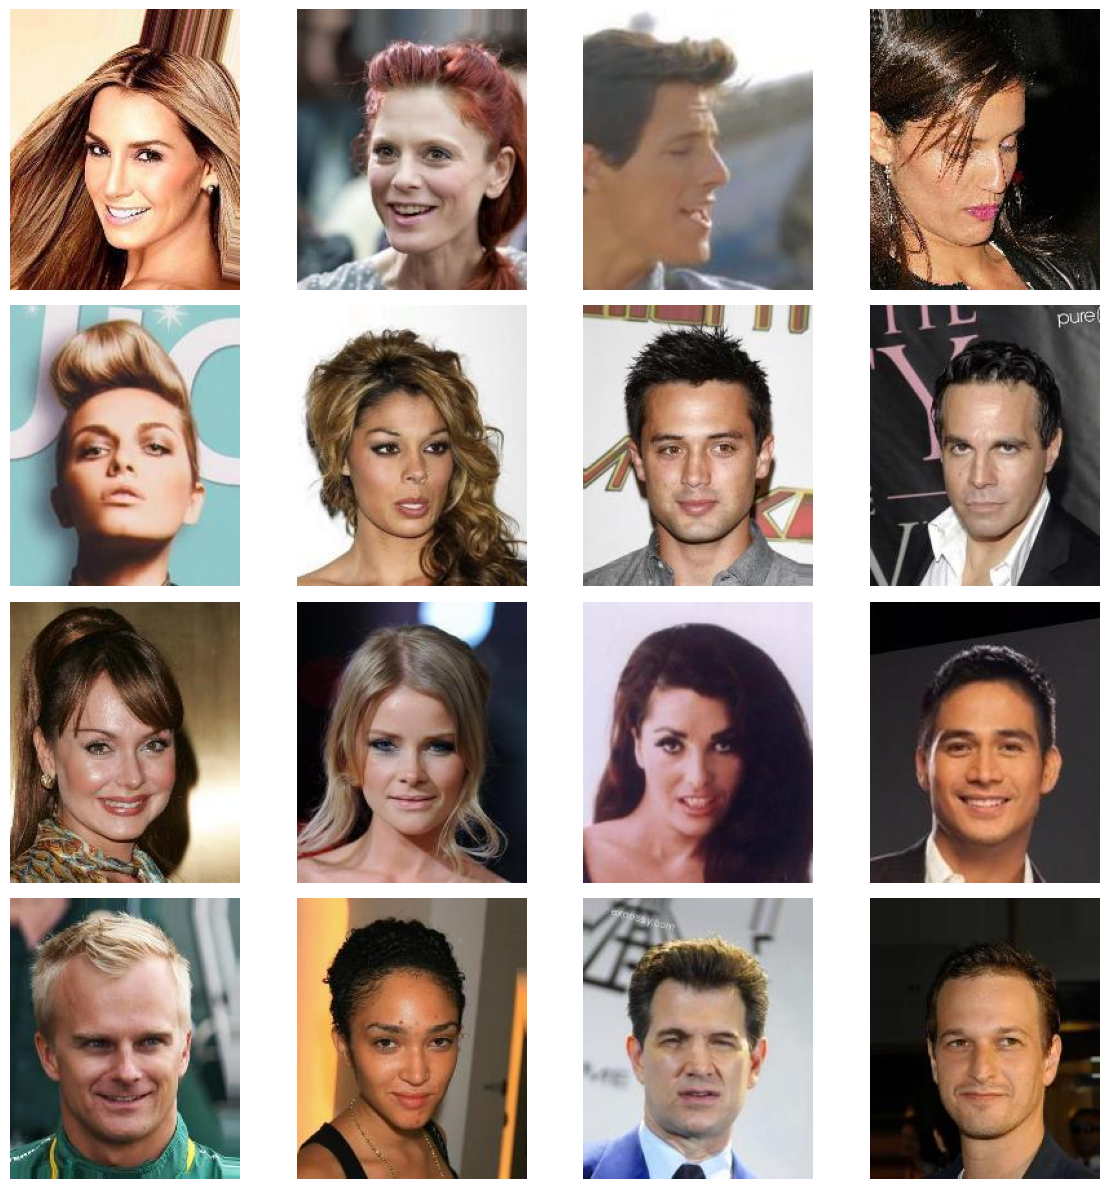

In [2]:
def show_images(dataset, num_samples=16, cols=4):
    """ Plots some samples from the dataset without excessive blank space """
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust size dynamically
    
    for i in range(rows * cols):  # Loop through all positions
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]  # Handle single row case
        
        if i < num_samples:
            img, _ = dataset[i]  # Get image and ignore label
            ax.imshow(img)
        ax.axis("off")  # Hide axis

    plt.tight_layout()
    plt.show()

data = torchvision.datasets.CelebA(root="../data", download=True)
show_images(data, SHOW_SAMPLES, SHOW_COLS)

## 1. Building Noise Scheduler

In [3]:
def linear_beta_transform(timesteps, start, end):
    """
    Return beta scheduler used in image noising process
    """
    return torch.linspace(start, end, timesteps)

def get_time_index(vals, t, x_shape):
    """ 
    Returns value of pre-computed list at a certain timestamp t.
    Also, re-shape it to match input shape to avoid shape mismatches.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion(x_0, device, t, sqrt_alphas_cumprod, 
                      sqrt_one_minus_alphas_cumprod):
    """
    Adds noise to a particular image with respect to a timestamp.
    """
    # Sample from Standard Gaussian Noise
    noise = torch.randn_like(x_0).to(device)
    
    # Square root of alpha values at timestamp t
    sqrt_alphas_cumprod_t = get_time_index(
        sqrt_alphas_cumprod, 
        t, 
        x_0.shape
    )
    sqrt_one_minus_alphas_cumprod_t = get_time_index(
        sqrt_one_minus_alphas_cumprod,
        t,
        x_0.shape
    )
    
    # Mean and variance
    mean_t = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
    variance_t = sqrt_one_minus_alphas_cumprod_t.to(device) * noise
    
    return mean_t + variance_t, noise

In [4]:
# Pre-processing
betas = linear_beta_transform(T, BETA_START, BETA_END)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [5]:
def load_transformed_dataset():
    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Scale to [-1, 1]
    ])

    train = torchvision.datasets.CelebA(
        root="../data", 
        download=True, 
        transform=data_transform,
        split='train'
    )
    test = torchvision.datasets.CelebA(
        root="../data", 
        download=True, 
        transform=data_transform, 
        split='test'
    )

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image, time_step=-1):
    reverse_transforms = transforms.Compose([
        transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]), # Reverse Normalization
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 

    plt.imshow(reverse_transforms(image))
    
    if time_step == -1:
        plt.title("Original")
    else:
        plt.title(f"t = {time_step}")
    
    plt.axis(False);

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


Image Shape: torch.Size([128, 3, 64, 64])


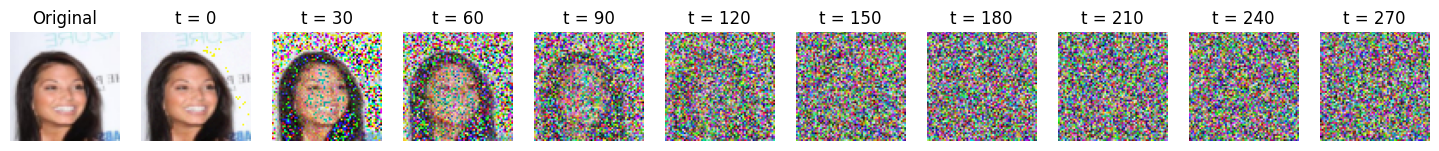

In [6]:
# Simulate forward diffusion with first image sample
image_sample = next(iter(dataloader))[0]
print(f"Image Shape: {image_sample.shape}")

plt.figure(figsize=(20, 15))

num_images = 10
step_size = int(T / num_images)

plt.subplot(1, num_images + 2, 1)
show_tensor_image(image_sample)
plt.axis(False);

for i in range(0, T, step_size):
    t = torch.tensor([i], dtype=torch.int64)
    plt.subplot(1, num_images + 2, (i // step_size) + 2)
    
    image, noise = forward_diffusion(
        image_sample,
        device,
        t,
        sqrt_alphas_cumprod, 
        sqrt_one_minus_alphas_cumprod
    )
    
    show_tensor_image(image, i)

## 2. Building U-Net

In [7]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        
        # Time embedding MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_ch),
            nn.ReLU()
        )
        
        self.conv1 = nn.Sequential(
            # If up=True, then due to residual connections, input=2*in_ch
            nn.Conv2d((up + 1) * in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
        # Additional conv for further spatial learning but preserves dimensions
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        
        if up: # If upscaling, then perform de-convolution
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else: # If downscaling, then perform convolution
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
    def forward(self, x, t):
        # First Conv
        h = self.conv1(x)

        # Time embedding
        time_emb = self.time_mlp(t)
        time_emb = time_emb.view(*time_emb.shape, 1, 1) # Add 2 dimensions to match 'h'

        # Add time embedding to represent position
        h = h + time_emb

        # Second Conv
        h = self.conv2(h)

        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(1e4) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class U_Net(nn.Module):
    """
    A simple U-Net architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        conv_channels = (64, 128, 256, 512, 1024)
        n = len(conv_channels)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, conv_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([
            Block(conv_channels[i], conv_channels[i+1], time_emb_dim) for i in range(n-1)
        ])
        
        # Upsample (reverses process for channels)
        self.ups = nn.ModuleList([
            Block(conv_channels[i], conv_channels[i-1], time_emb_dim, up=True) for i in range(n-1, 0, -1)
        ])

        self.output = nn.Conv2d(conv_channels[0], out_dim, 1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        
        # Initial conv
        x = self.conv0(x)

        residual_inputs = []
        
        for down_sample_block in self.downs:
            x = down_sample_block(x, t)
            residual_inputs.append(x)
        
        for up_sample_block in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up_sample_block(x, t)

        return self.output(x)
    
model = U_Net()
print("Parameter Count: ", sum(p.numel() for p in model.parameters()))
model

Parameter Count:  62438883


U_Net(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
      )
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): Block(
      (time_mlp): Sequential(

## 3. Sampling

In [8]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_time_index(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_time_index(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_time_index(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_time_index(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(T-1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()        

## 4. Training Diffusion Model

In [9]:
from torch.optim import Adam
model.to(device)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      x_noisy, noise = forward_diffusion(
        batch[0], 
        device, 
        t, 
        sqrt_alphas_cumprod, 
        sqrt_one_minus_alphas_cumprod
      )
      noise_pred = model(x_noisy, t)
      
      loss = F.l1_loss(noise, noise_pred)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()